In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import cv2
import glob
import os

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
files=glob.glob('/content/drive/My Drive/p/*.jpg')

In [4]:
images=np.array([cv2.imread(path) for path in files])

In [5]:
images.shape

(200,)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f46e3cf1c18>,
      dtype=object)

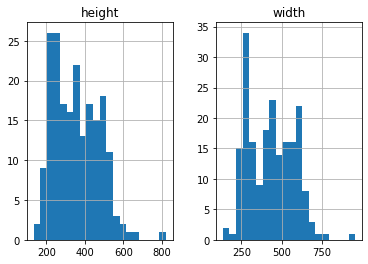

In [6]:
images_df=pd.DataFrame(images,columns=['image'])

images_df['width']=images_df['image'].apply(lambda x:x.shape[0])
images_df['height']=images_df['image'].apply(lambda x:x.shape[1])

images_df[['height','width']].hist(bins=20)

In [7]:
images_df[['height','width']].describe()

,height,width
count,200.000000,200.000000
mean,355.505000,433.720000
std,116.785247,142.059481
min,134.000000,135.000000
25%,252.000000,298.750000
50%,345.000000,435.500000
75%,447.250000,554.000000
max,821.000000,957.000000


In [8]:
images=np.array([cv2.resize(image,(128,128)) for image in images])

In [9]:
labels=np.concatenate((np.ones(100),np.zeros((100))))

In [10]:
labels.shape

(200,)

In [11]:
indicies=np.random.permutation(100)
train_true_idx,test_true_idx=indicies[:90],indicies[90:]
train_false_idx,test_false_idx=indicies[:90]+100,indicies[90:]+100

train_idx,test_idx=np.append(train_true_idx,train_false_idx),np.append(test_true_idx,test_false_idx)

trainX,trainY=images[train_idx],labels[train_idx]
testX,testY=images[test_idx],labels[test_idx]

In [12]:
print(trainX.shape, testX.shape)
print(trainY.shape, testY.shape)

(180, 128, 128, 3) (20, 128, 128, 3)
(180,) (20,)


In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Flatten, Dropout, Conv2D,MaxPooling2D,GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import math

In [14]:
train_image_data=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
)

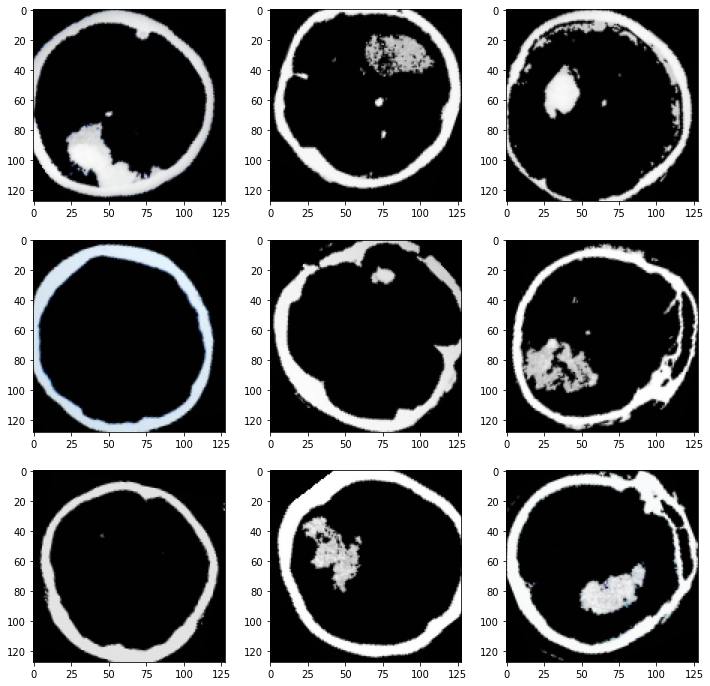

In [15]:
plt.figure(figsize=(12,12))
for x_batch in train_image_data.flow(trainX,batch_size=9):
  for i in range(0,9):
    plt.subplot(330+1+i)
    plt.imshow(x_batch[i])

  plt.show()
  break

In [25]:
def check_accuracy(model, setX, actual, print_images=True):
    predicted = np.array([int(x[0] > 0.5) for x in model.predict(setX)])
    if print_images:
        rows = math.ceil(len(predicted)/10.)
        plt.figure(figsize=(20, 3 * rows))
        for i in range(len(predicted)):
            plt.subplot(rows, 10, i+1)
            plt.imshow(setX[i])
            plt.title("pred "+str(predicted[i])+" actual "+str(actual[i]))
        
    confusion = confusion_matrix(actual, predicted)
    tn, fp, fn, tp = confusion.ravel()
    print("True positive:", tp, ", True negative:", tn,
          ", False positive:", fp, ", False negative:", fn)

    print("Total accuracy:", np.sum(predicted==actual) / len(predicted) * 100., "%")
    return (tn, fp, fn, tp)

In [17]:
def simple_conv_model(input_shape):
  model=Sequential()
  model.add(Conv2D(32,kernel_size=3,strides=2,activation='relu',
                   padding='same',input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(32,kernel_size=3,strides=2,activation='relu',
                   padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(64,kernel_size=3,strides=2,activation='relu',
                   padding='same'))
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.4))

  model.add(Dense(32,activation='relu'))
  model.add(Dropout(0.4))

  model.add(Dense(1,activation='sigmoid'))

  return model

In [18]:
model=simple_conv_model((128,128,3))
model.compile(loss='binary_crossentropy',optimizer='rmsprop',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

In [20]:
train_data=train_image_data.flow(trainX,trainY,batch_size=16)

In [21]:
x=model.fit(train_data,
                    validation_data=train_image_data.flow(testX,testY,batch_size=16),
                    validation_steps=16,
                    callbacks=[ModelCheckpoint("weights.h5", monitor='val_accuracy', 
                                               save_best_only=True, mode='max')],
                    epochs=50)

Epoch 1/50
12/12 [==============================] - 1s 68ms/step - loss: 0.7023 - accuracy: 0.5444 - val_loss: 0.6910 - val_accuracy: 0.6000
Epoch 2/50
12/12 [==============================] - 1s 43ms/step - loss: 0.6979 - accuracy: 0.5444
Epoch 3/50
12/12 [==============================] - 1s 49ms/step - loss: 0.6975 - accuracy: 0.5278
Epoch 4/50
12/12 [==============================] - 1s 46ms/step - loss: 0.6918 - accuracy: 0.5278
Epoch 5/50
12/12 [==============================] - 1s 45ms/step - loss: 0.6941 - accuracy: 0.5222
Epoch 6/50
12/12 [==============================] - 1s 45ms/step - loss: 0.6931 - accuracy: 0.5222
Epoch 7/50
12/12 [==============================] - 1s 44ms/step - loss: 0.6948 - accuracy: 0.4667
Epoch 8/50
12/12 [==============================] - 1s 44ms/step - loss: 0.6889 - accuracy: 0.5667
Epoch 9/50
12/12 [==============================] - 1s 44ms/step - loss: 0.6927 - accuracy: 0.4611
Epoch 10/50
12/12 [==============================] - 1s 44ms/step -

True positive: 10 , True negative: 4 , False positive: 6 , False negative: 0
Total accuracy: 70.0 %


(4, 6, 0, 10)

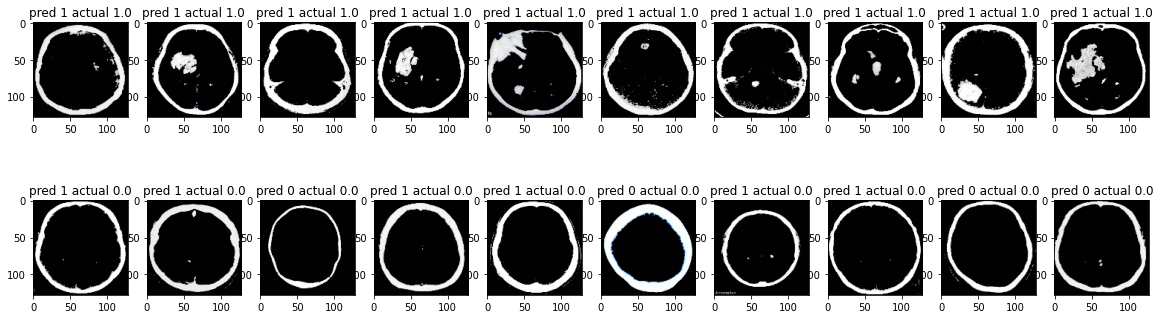

In [26]:
check_accuracy(model, testX/255., testY)